In [3]:
proj_name = 'MINDLAB2020_MEG-AuditoryPatternRecognition'
wdir = '/projects/' + proj_name + '/scratch/working_memory/'
scripts_dir = '/projects/' + proj_name + '/scripts/working_memory/'
import sys
sys.path.append(scripts_dir)


In [4]:
import mne
import numpy as np
from matplotlib import pyplot as plt
from stormdb.access import Query
from pickle import load
from scipy import stats
from mne.datasets import sample
from mne.stats import spatio_temporal_cluster_1samp_test
import os
import pickle
from copy import deepcopy
from sys import argv
from src.group_stats import do_stats
os.environ['ETS_TOOLKIT'] = 'qt4'
os.environ['QT_API'] = 'pyqt5'


In [5]:
wdir = '/projects/' + proj_name + '/scratch/working_memory/'
data_dir = wdir + 'averages/data/'
subs_dir = '/projects/' + proj_name + '/scratch/fs_subjects_dir/'
sample_path = sample.data_path()
sample_subjects_dir = sample_path + '/subjects'
# src_sample = mne.read_source_spaces(sample_subjects_dir +
#                                     '/fsaverage/bem/fsaverage-vol-5-src.fif')
src_sample = mne.read_source_spaces(subs_dir +
                                    'fsaverage/bem/fsaverage-vol-5-src.fif')
stats_dir = wdir + 'results/stats/'

    Reading a source space...
    [done]
    1 source spaces read


In [6]:
# Load and morph a source time course
dfname = data_dir + '0021_LZW_TFR_src2_delta.p'
dfile = open(dfname,'rb')
all_stc = pickle.load(dfile)
dfile.close()
stc = deepcopy(all_stc['same'])
del all_stc

# load source morph
morph = mne.read_source_morph(subs_dir + '0021_LZW/bem/0021_LZW_vol-morph.h5')
stc = morph.apply(stc)
print(stc)

<VolSourceEstimate | 14343 vertices, subject : fsaverage, tmin : -1250.0 (ms), tmax : 6500.0 (ms), tstep : 10.0 (ms), data shape : (14343, 776), ~85.0 MB>


In [11]:
qr = Query(proj_name)
subjects = qr.get_subjects()
subs = range(11,20)
b = 'theta'
times = [0, 4]

In [12]:
method = 'montecarlo'
all_data = {}
conds = ['maintenance/mel1','maintenance/mel2','manipulation/mel1','manipulation/mel2']
for sidx,s in enumerate(subs):
    try:
        scode = subjects[s-1]
        dfname = data_dir + scode + '_TFR_src2_' + b + '.p'
        print('loading file {}'.format(dfname))
        dfile = open(dfname,'rb')
        curdata = load(dfile)
        dfile.close()
        morph = mne.read_source_morph(subs_dir + scode + '/bem/' + scode + '_vol-morph.h5')
        morph_mat = morph.vol_morph_mat
        if sidx == 0:
            all_data =  {}
        for cd in conds:
            cdata = morph_mat.dot(curdata[cd].crop(times[0],times[1]).data)#deepcopy(cmorphed.data) #morph_mat.dot(c.data)
            print('appending subject {} band {} condition {}'.format(scode,b,cd))
            all_data.setdefault(cd,np.array([cdata]))
            if sidx > 0:
                all_data[cd] = np.vstack((all_data[cd],np.array([cdata])))
    except Exception as e:
        print(e)
        continue


loading file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0011_U7X_TFR_src2_theta.p
appending subject 0011_U7X band theta condition maintenance/mel1
appending subject 0011_U7X band theta condition maintenance/mel2
appending subject 0011_U7X band theta condition manipulation/mel1
appending subject 0011_U7X band theta condition manipulation/mel2
loading file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0012_VK2_TFR_src2_theta.p
appending subject 0012_VK2 band theta condition maintenance/mel1
appending subject 0012_VK2 band theta condition maintenance/mel2
appending subject 0012_VK2 band theta condition manipulation/mel1
appending subject 0012_VK2 band theta condition manipulation/mel2
loading file /projects/MINDLAB2020_MEG-AuditoryPatternRecognition/scratch/working_memory/averages/data/0013_NHJ_TFR_src2_theta.p
appending subject 0013_NHJ band theta condition maintenance/mel1
appending subject 0013_N

In [13]:
# Do grand average
grand_avg, src_avg = {}, {}
for cd in all_data:
    grand_avg[cd] = deepcopy(morph.apply(curdata[cd].crop(times[0],times[1])))
    #grand_avg[b][cd].subject = 'sample'
    grand_avg[cd].data = np.mean(all_data[cd],0)
    print(grand_avg[cd].data.shape)
    src_avg[cd] = deepcopy(stc)
    src_avg[cd].data = grand_avg[cd].data#*mask#
    src_avg[cd].tmin = times[0]

(14343, 401)
(14343, 401)
(14343, 401)
(14343, 401)


In [14]:
adjacency = mne.spatial_src_adjacency(src_sample)
stats_names = ['maintenance','manipulation','interaction']
conds_math = [['maintenance/mel2','maintenance/mel1'],['manipulation/mel2','manipulation/mel1'],
              ['maintenance/mel2','maintenance/mel1','manipulation/mel2','manipulation/mel1']]
conds_op = [['-',''],['-',''],['-','-','+','']]

-- number of adjacent vertices : 14343


In [17]:
stat_results = {}
for sidx, sn in enumerate(stats_names):
    print('Computing stats for the comparison: ' + sn + '\n\n')
    math_cmd = 'cdata = ('
    for cidx, cd in enumerate(conds_math[sidx]):
        math_cmd += 'all_data["' + cd + '"]' + conds_op[sidx][cidx]
    math_cmd += ')'#'/2'
    print('executing the following command:\n\n' + math_cmd)
    exec(math_cmd)
    print(cdata.shape)
    #stat_results[sn] = do_stats(cdata, method='FDR',adjacency=adjacency)
    stat_results[sn] = do_stats(cdata, method=method,adjacency=adjacency,n_permutations=1000)

print('\nsaving stats file\n\n')
stats_file = '{}TFR_{}_{}_{}-{}_new.py'.format(stats_dir, b, method, np.round(times[0],2), np.round(times[1],2))
sfile = open(stats_file,'wb')
pickle.dump(stat_results,sfile)
sfile.close()

Computing stats for the comparison: maintenance


executing the following command:

cdata = (all_data["maintenance/mel2"]-all_data["maintenance/mel1"])
(9, 14343, 401)
Two sided alpha level: 0.05 - t threshold: 2.306004135033371
Clustering.
stat_fun(H1): min=-7.276110 max=8.057944
Running initial clustering
Found 635 clusters
Permuting 255 times (exact test)...


/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/255 [00:00<?,       ?it/s]

Computing cluster p-values
Done.
Computing stats for the comparison: manipulation


executing the following command:

cdata = (all_data["manipulation/mel2"]-all_data["manipulation/mel1"])
(9, 14343, 401)
Two sided alpha level: 0.05 - t threshold: 2.306004135033371
Clustering.
stat_fun(H1): min=-7.616307 max=7.150229
Running initial clustering
Found 773 clusters


MemoryError: Unable to allocate 5.49 MiB for an array with shape (5751543,) and data type bool

In [16]:
stat_results

{'maintenance': {'mask': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'tvals': array([[ 0.46280441,  0.21506364, -0.05499174, ...,  0.52848262,
           0.45460479,  0.42412362],
         [ 0.63653206,  0.26856078, -0.05662483, ...,  0.69318869,
           0.62519103,  0.58406693],
         [ 0.30512862,  0.09262174, -0.11806061, ...,  0.38062524,
           0.25388157,  0.15721691],
         ...,
         [-0.65234208, -0.37124791, -0.19340885, ..., -0.19145559,
          -0.00943702,  0.102635  ],
         [ 0.03608398,  0.26408532,  0.45655084, ...,  0.0701044 ,
           0.26622801,  0.35311457],
         [ 0.64846068,  0.68187868,  0.73242534, ..., -0.10383716,
   

In [88]:
interaction = src_avg['maintenance/mel2'] - src_avg['maintenance/mel1'] - src_avg['manipulation/mel2'] + src_avg['manipulation/mel1'] 

In [89]:
maintenance = src_avg['maintenance/mel2'] - src_avg['maintenance/mel1']
manipulation = src_avg['manipulation/mel2'] - src_avg['manipulation/mel1'] 

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial position: [-20.0, -30.0, 50.0] mm
Showing: t = 2.005 s, (-20.0, -30.0, 50.0) mm, [12, 17, 25] vox, 32748 vertex


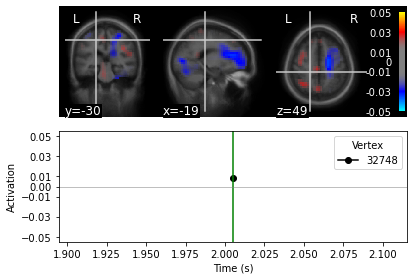

In [90]:
brain = interaction.copy().mean().plot(subjects_dir=subs_dir,clim={'kind': 'value', 'pos_lims': [0.01,0.03,0.05]},#time_viewer=True,
                     subject='fsaverage', mode = 'stat_map',src=src_sample,initial_pos=[-0.02,-0.03,0.05])

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial position: [50.0, -30.0, 10.0] mm
Showing: t = 2.450 s, (50.0, -30.0, 10.0) mm, [26, 17, 17] vox, 22466 vertex


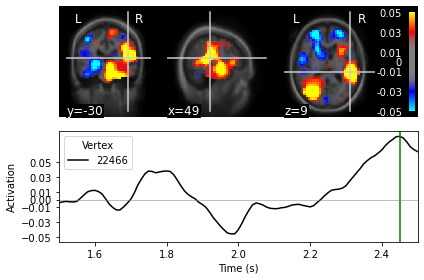

In [91]:
brain = interaction.plot(subjects_dir=subs_dir,clim={'kind': 'value', 'pos_lims': [0.01,0.03,0.05]},#time_viewer=True,
                     subject='fsaverage', mode = 'stat_map',src=src_sample,initial_pos=[0.05,-0.03,0.01])

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial time: 1.7 sec
Showing: t = 1.700 s, (35.0, -0.0, 40.0) mm, [23, 23, 23] vox, 30383 vertex


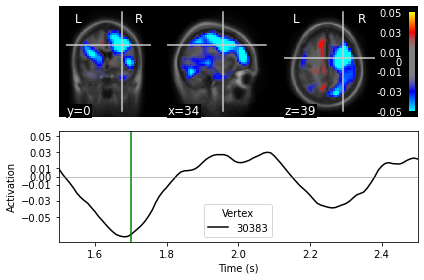

In [101]:
brain = maintenance.plot(subjects_dir=subs_dir,clim={'kind': 'value', 'pos_lims': [0.01,0.03,0.05]},initial_time=1.7,
                     subject='fsaverage', mode = 'stat_map',src=src_sample)#,initial_pos=[0.05,-0.03,0.01])

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial time: 1.7 sec
Showing: t = 1.700 s, (-45.0, -20.0, 45.0) mm, [7, 19, 24] vox, 31522 vertex


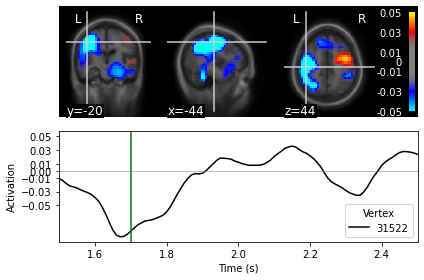

In [102]:
brain = manipulation.plot(subjects_dir=subs_dir,clim={'kind': 'value', 'pos_lims': [0.01,0.03,0.05]},initial_time=1.7,#time_viewer=True,
                     subject='fsaverage', mode = 'stat_map',src=src_sample)#,initial_pos=[0.05,-0.03,0.01])

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial time: 1.7 sec
Showing: t = 1.700 s, (40.0, -5.0, 45.0) mm, [24, 22, 24] vox, 31638 vertex


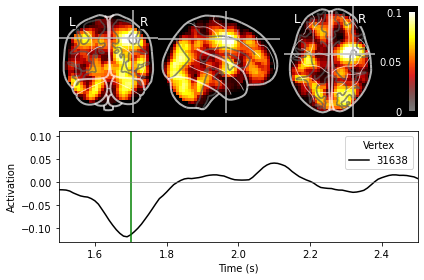

In [105]:
brain = interaction.plot(subjects_dir=subs_dir,clim={'kind': 'value', 'lims': [0,0.05,0.1]},#time_viewer=True,
                     subject='fsaverage', mode = 'glass_brain',src=src_sample,initial_time=1.7)

/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/users/david/miniconda3/envs/mne/lib/python3.9/site-packages/mne/utils/check.py:92: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):


Fixing initial time: 1.7 sec
Showing: t = 1.700 s, (40.0, -5.0, 45.0) mm, [24, 22, 24] vox, 31638 vertex


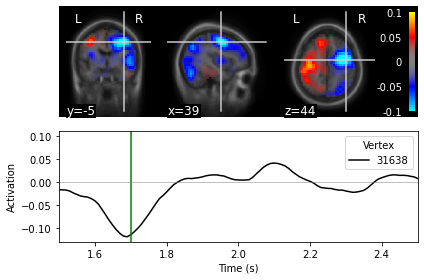

In [106]:
brain = interaction.plot(subjects_dir=subs_dir,clim={'kind': 'value', 'pos_lims': [0,0.05,0.1]},#time_viewer=True,

                     subject='fsaverage', mode = 'stat_map',src=src_sample,initial_time=1.7)

